# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
DATASET = 'MNIST'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [2]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [3]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from ipywidgets import widgets

from utilities.pathManager import fetchPaths
from utilities.utils import load_json

# Paths

In [5]:
paths = fetchPaths(base, DATASET, '', False)

path_bdd = paths['bdd'].parent
config = load_json(paths['configuration'])

flavors = config['configuration']['flavors']
batch_size = config['model_config']['batch_size']
lhl_neurons = config['configuration']['lhl_neurons']
optim = list(config['configuration']['optimizer'].keys())[0]

path_bdd

PosixPath('/home/ah19/runtime-monitoring/experiments/MNIST/bdd')

# Seed

In [6]:
np.random.seed(SEED)

# Import Data

In [7]:
model_names = []
for lhl in lhl_neurons:
    for flavor in flavors:
        model_names.append(f'{DATASET}_{optim}-{batch_size}-{lhl}/{flavor}')

In [8]:
model_names

['MNIST_SGD-32-5/raw',
 'MNIST_SGD-32-5/scaler_pca',
 'MNIST_SGD-32-30/raw',
 'MNIST_SGD-32-30/scaler_pca',
 'MNIST_SGD-32-60/raw',
 'MNIST_SGD-32-60/scaler_pca',
 'MNIST_SGD-32-100/raw',
 'MNIST_SGD-32-100/scaler_pca',
 'MNIST_SGD-32-150/raw',
 'MNIST_SGD-32-150/scaler_pca']

In [9]:
def read_df(path, f, lhl, bs):    
    d = pd.read_csv(path)
    d['flavor'] = f
    d['lhl'] = lhl
    d['batch_size'] = bs
    if path.name.find('top_third') != -1:
        d['subset_type'] = 'top third'
    elif path.name.find('gte_mean') != -1:
        d['subset_type'] = 'gte mean'
    else:
        d['subset_type'] = 'raw'
    return d

def collect_dfs(path, key, f, lhl, bs):
    t = []
    for p in path.glob(f'all*{key}*.csv'):
        t.append(read_df(p, f, lhl, bs))
    
    if t == []: return pd.DataFrame()
    return pd.concat(t)

In [10]:
df_info = pd.concat(
    [collect_dfs(path_bdd / f'{DATASET}_{optim}-{batch_size}-{lhl}/{flavor}', 'info', flavor, lhl, batch_size ) \
    for lhl, flavor in product(lhl_neurons, flavors)])

In [11]:
df_score = pd.concat(
    [collect_dfs(path_bdd / f'{DATASET}_{optim}-{batch_size}-{lhl}/{flavor}', 'scores', flavor, lhl, batch_size ) \
    for lhl, flavor in product(lhl_neurons, flavors)])

In [12]:
df_info

,thld,eta,build_time_min,size_mb,reorder_time_min,num_patterns,num_unique_patterns_%,num_reorder,num_neurons,start_time,end_time,flavor,lhl,batch_size,subset_type
0,qth_0.9,0.0,0.1,4303.393,0.0,57011.0,0.0,0.0,1.0,2023-07-28 17:19:59,2023-07-28 17:19:59,raw,5,32,top third
1,qth_0.9,1.0,0.0,4303.393,0.0,1.0,0.0,0.0,1.0,2023-07-28 17:19:59,2023-07-28 17:19:59,raw,5,32,top third
2,qth_0.9,2.0,0.0,4303.393,0.0,0.0,0.0,0.0,1.0,2023-07-28 17:20:00,2023-07-28 17:20:00,raw,5,32,top third
3,qth_0.9,3.0,0.0,4303.393,0.0,0.0,0.0,0.0,1.0,2023-07-28 17:20:01,2023-07-28 17:20:01,raw,5,32,top third
4,qth_0.9,4.0,0.0,4303.393,0.0,0.0,0.0,0.0,1.0,2023-07-28 17:20:01,2023-07-28 17:20:01,raw,5,32,top third
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,mean,0.0,551.2,5454.816,0.0,58136.0,100.0,0.0,150.0,2023-07-30 03:53:35,2023-07-30 03:59:06,scaler_pca,150,32,raw
31,mean,1.0,51087.0,6694.509,0.0,4376230.0,1.0,0.0,150.0,2023-07-30 04:06:47,2023-07-30 12:37:39,scaler_pca,150,32,raw
32,mean,2.0,25458.4,7996.446,0.0,2176447.0,1.0,0.0,150.0,2023-07-30 12:45:32,2023-07-30 17:00:07,scaler_pca,150,32,raw
33,mean,3.0,12098.0,8026.763,0.0,1082479.0,1.0,0.0,150.0,2023-07-30 17:07:42,2023-07-30 19:08:41,scaler_pca,150,32,raw


## Visualization

In [13]:
# merge flavor and subset_type column
df_score['flavor2'] = np.where(df_score['flavor'] == 'scaler_pca', 'scaler_pca', df_score['subset_type'])

In [14]:
# df_score['flavor2'].drop_duplicates()

In [15]:
# df_score.head(0)

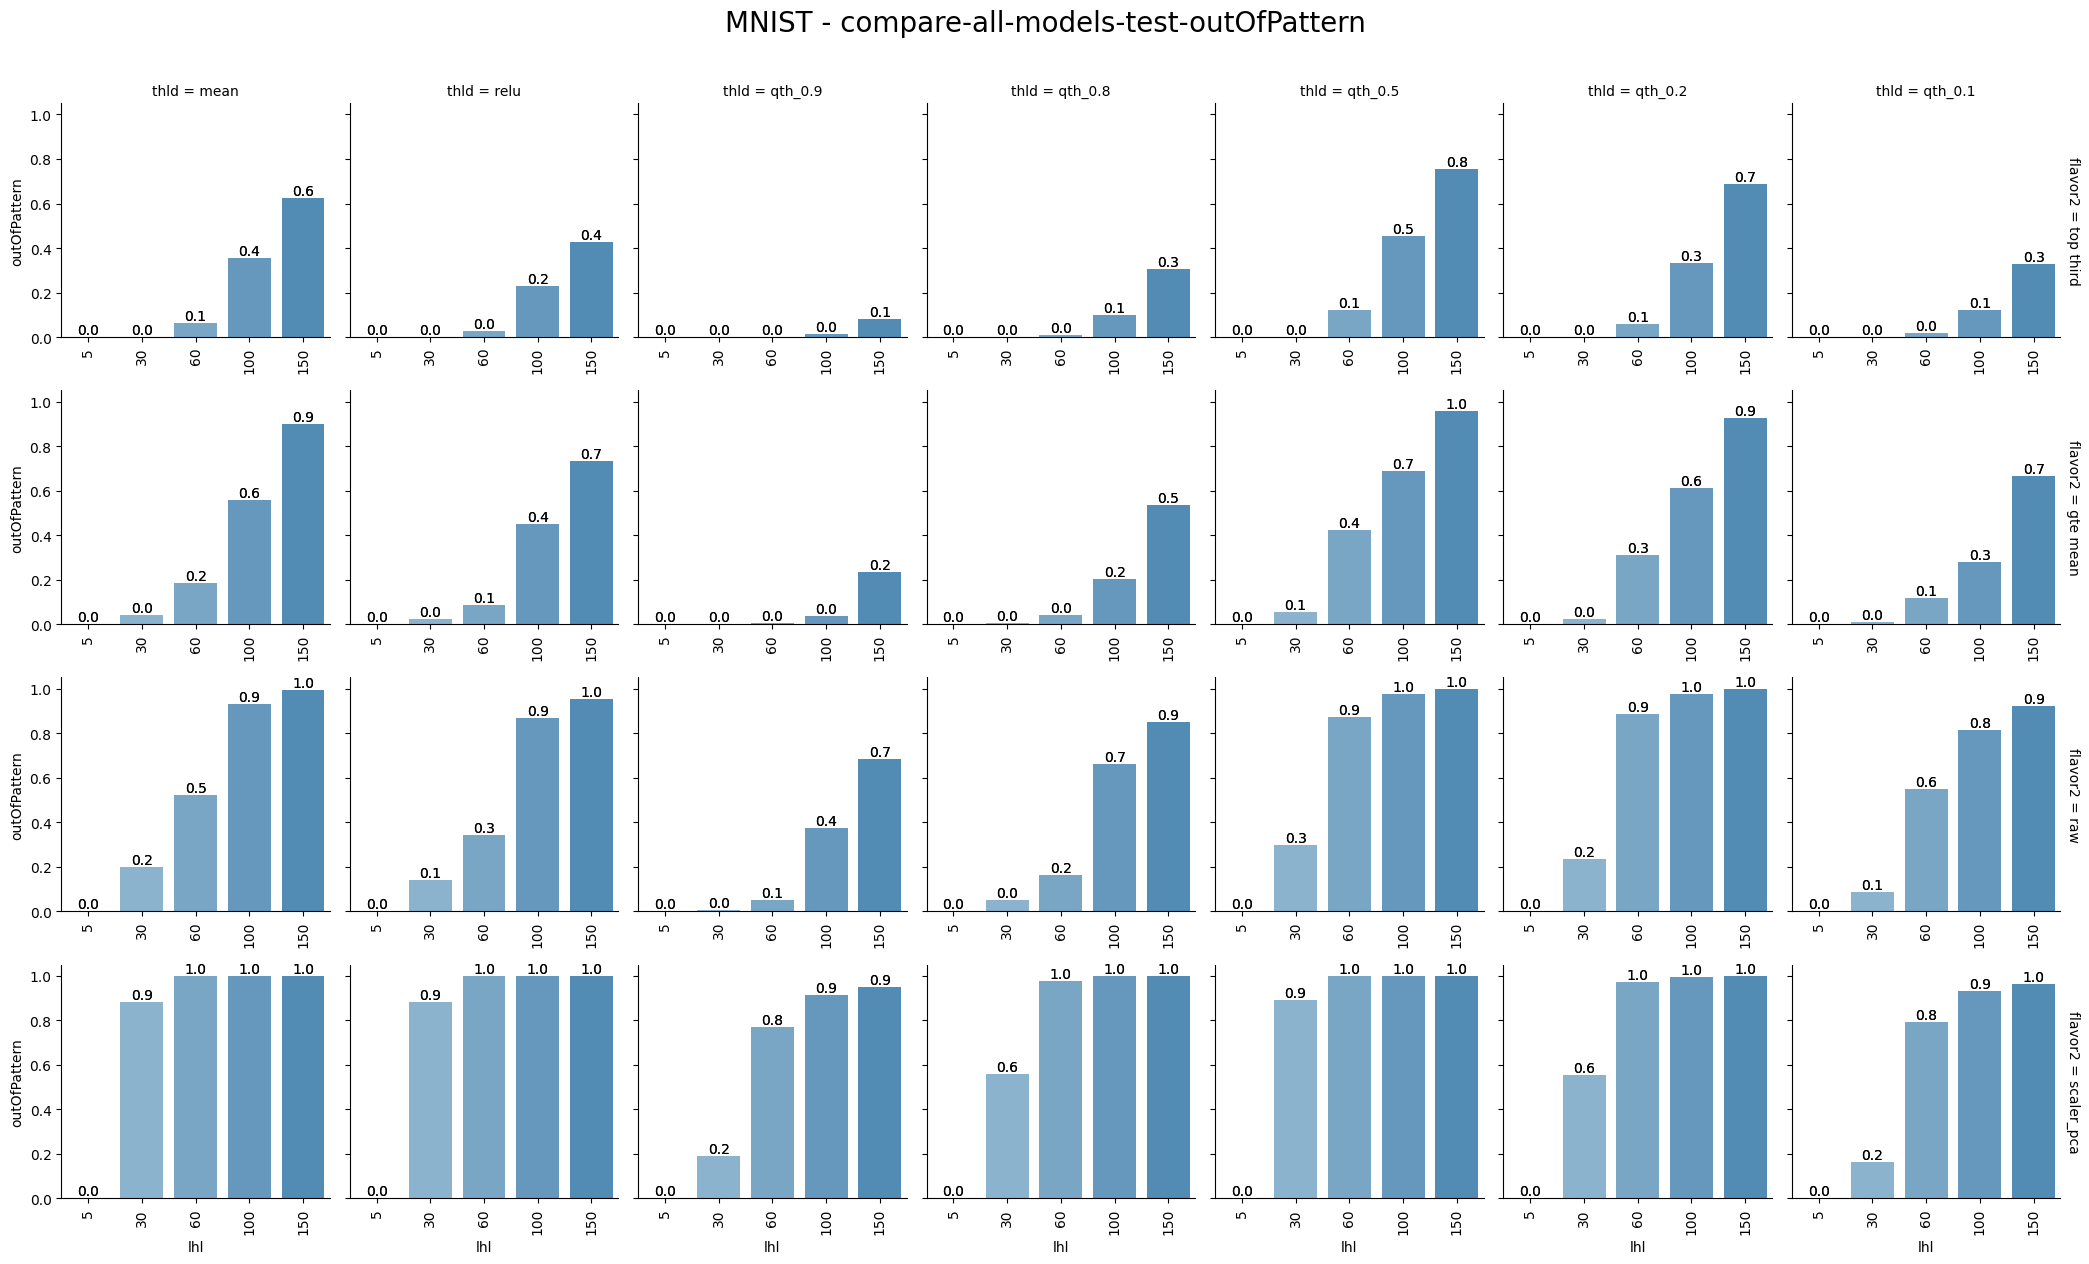

In [16]:
# which threshold is better for eta 0 and stage test
# rows are flavor2
# columns are thld
# bar for each lhl

stage = 'test'

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['stage'] == stage)

metric = "outOfPattern"
# metric = "outOfPatternMisclassified"

# df_score.loc[scores_best_thld]

palette = sns.color_palette('Blues_d', 10)
scores_best_thld_df = df_score.loc[scores_best_thld]

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="flavor2", margin_titles=True, sharex=False,
                   row_order=['top third', 'gte mean', 'raw', 'scaler_pca'],
                   col_order=['mean', 'relu', 'qth_0.9', 'qth_0.8', 'qth_0.5', 'qth_0.2', 'qth_0.1'])
sea.map(sns.barplot, "lhl", metric, errorbar=None, palette=palette)

for k, ax in sea.axes_dict.items():
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')
        
for k, ax in sea.axes_dict.items():
    # start y from 0
    ax.set_ylim(0)
    # add data labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')
    # rotate x axis
    for item in ax.get_xticklabels():
        item.set_rotation(90)
        
# sea.set_titles(row_template='', col_template='')

plt.tight_layout()
sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.05, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

In [17]:
# THLD = 'qth_0.5'
# FLAVOR = 'raw'
# LHL = 50
# STAGE = 'test'
# ETA = 0

# fltr = (df_score['thld'] == THLD) &\
#         (df_score['flavor2'] == FLAVOR) &\
#         (df_score['lhl'] == LHL) &\
#         (df_score['stage'] == STAGE) &\
#         (df_score['eta'] == ETA)

# df_score.loc[fltr]

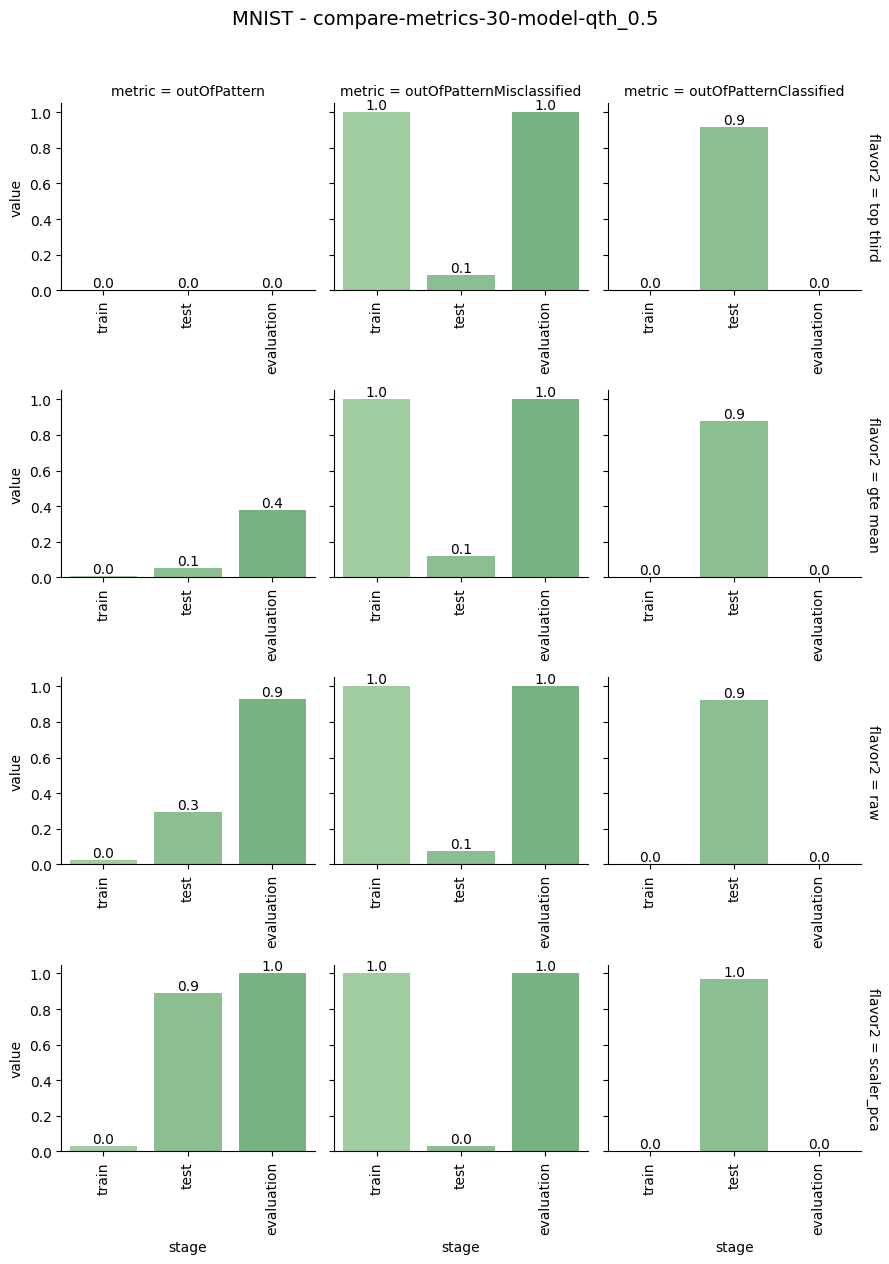

In [18]:
# show metrics is better for eta 0
# rows are flavor2
# columns are metrics
# bar for each stage

lhl = 30
thld = 'qth_0.5'

scores_best_bdd = (df_score['y'] == 'all') & \
    (df_score['lhl'] == lhl) & \
    (df_score['eta'] == 0) & \
    (df_score['thld'] == thld)



# df_score.loc[scores_best_thld]

palette = sns.color_palette('Greens_d', 10)
scores_best_flavor_df = df_score.loc[scores_best_bdd]

scores_best_flavor_df = scores_best_flavor_df.drop(['count', 'false', 'false_misclassified', 'false_classified'], axis=1)

scores_best_flavor_df = scores_best_flavor_df.melt(
    id_vars=['y', 'eta', 'stage', 'thld', 'flavor', 'lhl', 'batch_size', 'subset_type','flavor2'],
    var_name='metric', value_name='value'
)

sea = sns.FacetGrid(scores_best_flavor_df, col="metric", row="flavor2", margin_titles=True, sharex=False,
                   row_order=['top third', 'gte mean', 'raw', 'scaler_pca']
)
sea.map(sns.barplot, "stage", "value", errorbar=None, palette=palette)

for k, ax in sea.axes_dict.items():
    # start y from 0
    ax.set_ylim(0)
    # add data labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')
    # rotate x axis
    for item in ax.get_xticklabels():
        item.set_rotation(90)
        
# sea.set_titles(row_template='', col_template='')

plt.tight_layout()
sea.fig.suptitle(f'{DATASET} - compare-metrics-{lhl}-model-{thld}', y=1.05, fontsize=14)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

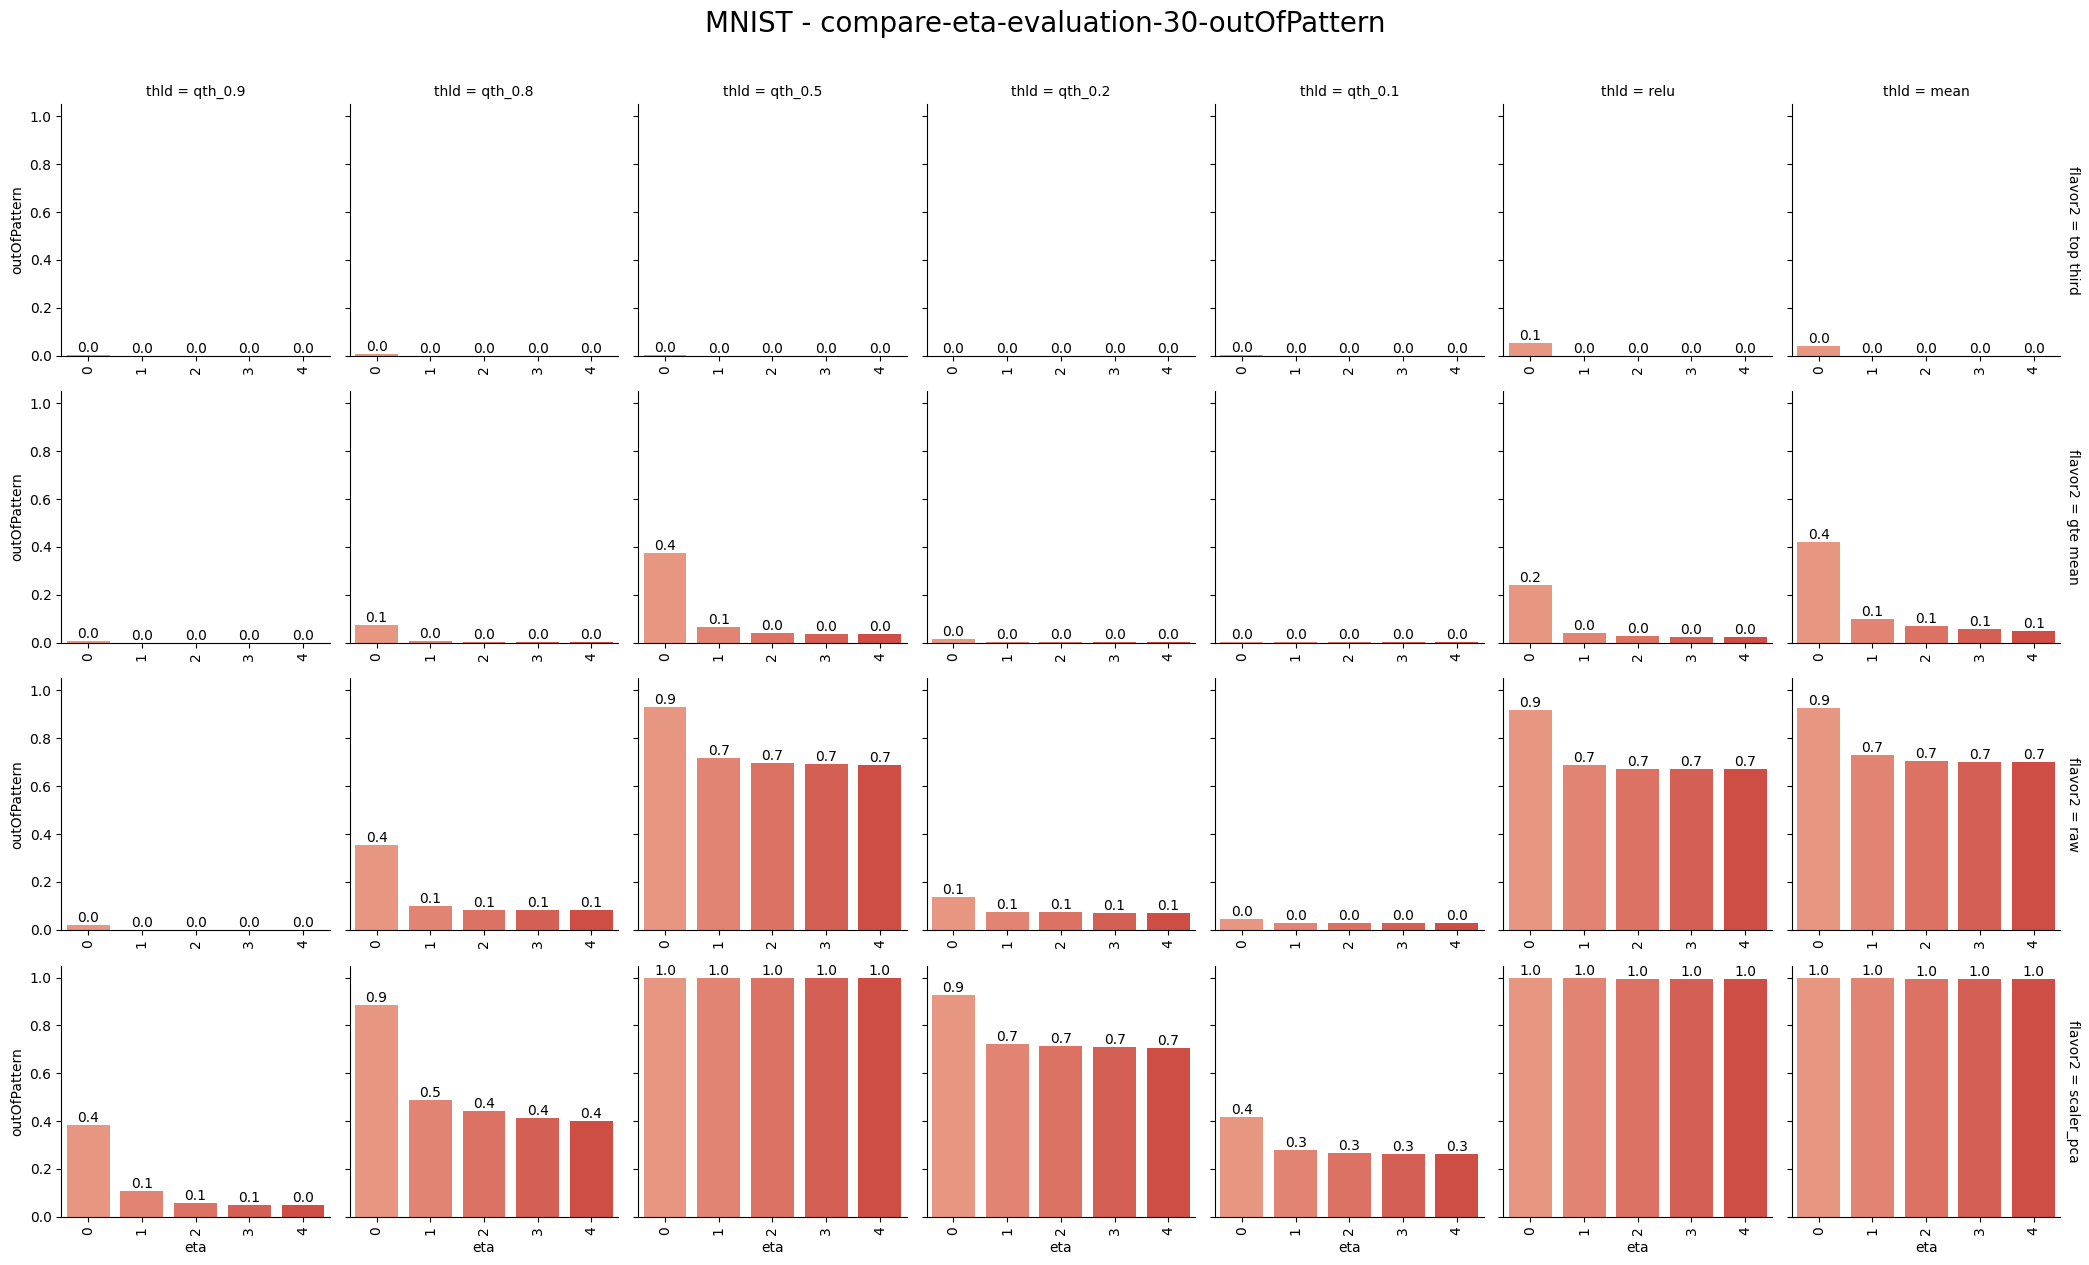

In [19]:
# show metrics is better for eta 0
# rows are flavor2
# columns are metrics
# bar for each stage

lhl = 30
stage = 'evaluation'

scores_best_bdd = (df_score['y'] == 'all') & \
    (df_score['lhl'] == lhl) & \
    (df_score['stage'] == stage)



metric = "outOfPattern"
# metric = "outOfPatternMisclassified"

palette = sns.color_palette('Reds_d', 10)
scores_best_eta_df = df_score.loc[scores_best_bdd]

sea = sns.FacetGrid(scores_best_eta_df, col="thld", row="flavor2", margin_titles=True, sharex=False,
                   row_order=['top third', 'gte mean', 'raw', 'scaler_pca']
)
sea.map(sns.barplot, "eta", metric, errorbar=None, palette=palette)


for k, ax in sea.axes_dict.items():
    # start y from 0
    ax.set_ylim(0)
    # add data labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')
    # rotate x axis
    for item in ax.get_xticklabels():
        item.set_rotation(90)
        
# # sea.set_titles(row_template='', col_template='')

plt.tight_layout()
sea.fig.suptitle(f'{DATASET} - compare-eta-{stage}-{lhl}-{metric}', y=1.05, fontsize=20)

# # plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

In [ ]:
# # one model
# # compare one model

# filter_one_model = (df_score['lhl'] = LHL) &\
#     (df_score['lhl'] = LHL) &\
#     (df_score['lhl'] = LHL) &\
#     (df_score['lhl'] = LHL)

# filter_one_model_df = df_score.loc[filter_one_model]

# # fig, ax = plt.subplots(1, 4, figsize=(14, 8))

# # sns.barplot


# Analyze last hidden layer data

### Train vs Test

In [22]:
LHL = 60
FLAVOR = 'raw'

POSTFIX = f"{optim}-{batch_size}-{LHL}"
path_lhl = paths['lhl'].parent / f"{DATASET}_{POSTFIX}" / FLAVOR
path_lhl

PosixPath('/home/ah19/runtime-monitoring/experiments/MNIST/last-hidden-layer/MNIST_SGD-32-60/raw')

In [29]:
col_drop = ['true', 'y']

df_train = pd.read_csv(path_lhl / f"{DATASET}_{POSTFIX}_{FLAVOR}_train.csv")
df_test = pd.read_csv(path_lhl / f"{DATASET}_{POSTFIX}_{FLAVOR}_test.csv")
df_eval = pd.read_csv(path_lhl / f"{DATASET}_{POSTFIX}_{FLAVOR}_evaluation.csv")

df_train.shape, df_test.shape, df_eval.shape

((60000, 62), (9984, 62), (1000, 62))

In [24]:
print(f"Train accuracy: {round(df_train['true'].sum() / df_train.shape[0], 4)*100}")
print(f"Test accuracy: {round(df_test['true'].sum() / df_test.shape[0], 4)*100}")
print(f"Evaluation accuracy: {round(df_eval['true'].sum() / df_eval.shape[0], 4)*100}")

Train accuracy: 98.44000000000001
Test accuracy: 98.26
Evaluation accuracy: 100.0


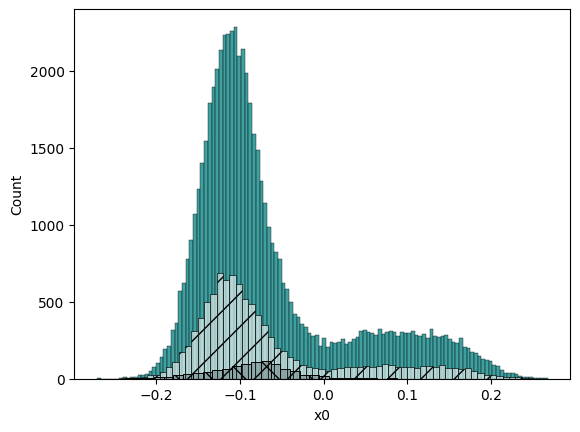

In [25]:
col = 'x0'

sns.histplot(df_train[col], label=f'Train {col}', color='teal')
sns.histplot(df_test[col], label=f'Test {col}', color='white', alpha=0.6, hatch='/')
sns.histplot(df_eval[col], label=f'Evaluation {col}', color='black', alpha=0.2, hatch='\\')

plt.show()

In [27]:
# @widgets.interact(col=df_train.columns[:-2])
# def hist_neuron(col):
#     plt.close('all')
#     sns.histplot(df_train[col], label=f'Train {col}', color='teal')
#     sns.histplot(df_test[col], label=f'Test {col}', color='white', alpha=0.6, hatch='/')
#     sns.histplot(df_eval[col], label=f'Evaluation {col}', color='black', alpha=0.2, hatch='\\')

#     plt.show()

## Statistic Test

In [31]:
from scipy.stats import ks_2samp, anderson_ksamp


# Generate example non-normally distributed data for demonstration
np.random.seed(42)
d1 = df_test.drop(col_drop, axis=1).to_numpy()
d2 = df_eval.drop(col_drop, axis=1).to_numpy()


# two-sided: The null hypothesis is that the two distributions are identical,
# F(x)=G(x) for all x; the alternative is that they are not identical.
# The statistic is the maximum absolute difference between
# the empirical distribution functions of the samples.


# The k-sample Anderson-Darling test is a modification of the one-sample Anderson-Darling test.
# It tests the null hypothesis that k-samples are drawn from the same population
# without having to specify the distribution function of that population.
# The critical values depend on the number of samples.



# Initialize lists to store test results
ks_results = []
ad_results = []

# Loop through columns and perform tests
for col in range(d1.shape[1]):
    d1_col = d1[:, col]
    d2_col = d2[:, col]
    
    # Kolmogorov-Smirnov test
    ks_statistic, ks_p_value = ks_2samp(d1_col, d2_col)
    ks_results.append((ks_statistic, ks_p_value))
    
    # Anderson-Darling test
    ad_statistic, ad_critical_values, ad_significance_levels = anderson_ksamp([d1_col, d2_col])
    ad_results.append((ad_statistic, ad_critical_values, ad_significance_levels))
    

# Print test results
for col in range(d1.shape[1]):
    print(f"Column {col + 1}:\n")
    
    ks_statistic, ks_p_value = ks_results[col]
    print(f"Kolmogorov-Smirnov test: Statistic = {ks_statistic:.4f}, p-value = {ks_p_value:.4e}")
    
    ad_statistic, _, ad_significance_levels = ad_results[col]
    print(f"Anderson-Darling test: Statistic = {ad_significance_levels:.4f}")
    
    print("=" * 50)

Column 1:

Kolmogorov-Smirnov test: Statistic = 0.1599, p-value = 9.1403e-21
Anderson-Darling test: Statistic = 0.0010
Column 2:

Kolmogorov-Smirnov test: Statistic = 0.2499, p-value = 1.9764e-50
Anderson-Darling test: Statistic = 0.0010
Column 3:

Kolmogorov-Smirnov test: Statistic = 0.3507, p-value = 3.1292e-100
Anderson-Darling test: Statistic = 0.0010
Column 4:

Kolmogorov-Smirnov test: Statistic = 0.2845, p-value = 1.6149e-65
Anderson-Darling test: Statistic = 0.0010
Column 5:

Kolmogorov-Smirnov test: Statistic = 0.3715, p-value = 8.6803e-113
Anderson-Darling test: Statistic = 0.0010
Column 6:

Kolmogorov-Smirnov test: Statistic = 0.4333, p-value = 5.2955e-155
Anderson-Darling test: Statistic = 0.0010
Column 7:

Kolmogorov-Smirnov test: Statistic = 0.3605, p-value = 4.7293e-106
Anderson-Darling test: Statistic = 0.0010
Column 8:

Kolmogorov-Smirnov test: Statistic = 0.1784, p-value = 9.0951e-26
Anderson-Darling test: Statistic = 0.0010
Column 9:

Kolmogorov-Smirnov test: Statisti

In [57]:
# Find the significance level closest to your test statistic
# closest_level_idx = np.argmin(np.abs(ad_significance_levels - ad_statistic))
closest_level_idx = np.argmin(np.abs(list(map(lambda x: x[2]-x[0] , ad_results))))
closest_level_idx

25

In [60]:
ad_results[closest_level_idx][2]

0.1358711703816555

In [62]:
# Use the index to get the corresponding p-value
# p_value = 1 - ad_significance_levels[closest_level_idx]
p_value = 1 - ad_results[closest_level_idx][2]

print(f"Anderson-Darling test statistic: {ad_results[closest_level_idx][0]:.4f}")
print(f"Approximate p-value: {p_value:.4f}")

Anderson-Darling test statistic: 0.9263
Approximate p-value: 0.8641


In [53]:
map(lambda x: x[2]-x[0] , ad_results)